# **Symmetric Cross Entropy Learning and Proposed method**
## The following project implements multiclass classification on MNIST dataset with balanced, imbalanced and noisy data using Symmetric Cross Entropy Learning
    


# Libraries

In [244]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.svm import SVC, LinearSVC
#from thundersvm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,precision_recall_curve,average_precision_score,PrecisionRecallDisplay,roc_curve,auc,f1_score
import numpy
import matplotlib.pyplot as matplot
from collections import Counter
from imblearn.datasets import make_imbalance
import numpy as np
import os
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.preprocessing import label_binarize
from keras.utils import np_utils
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import BaggingClassifier
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import log
from sklearn.metrics import average_precision_score,precision_score
from imblearn.over_sampling import SMOTE

import warnings

In [245]:
warnings.filterwarnings("ignore")

# Functions to be implemented

In [246]:
def load_data():
  (X_train,y_train),(X_test,y_test) = mnist.load_data() 
  return X_train,y_train,X_test,y_test

In [247]:
def preprocess(X_train,y_train,X_test,y_test):
  X_train = X_train.reshape(-1, 28, 28, 1)
  X_test = X_test.reshape(-1, 28, 28, 1)
  X_train = X_train / 255.0
  X_test = X_test / 255.0
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  y_train_clean = np.copy(y_train)
  Y_clean_train = np.copy(y_train)
  Y_clean_test = np.copy(y_test)

# # one-hot-encode the labels
  y_train_clean = np_utils.to_categorical(y_train_clean, 10)
  y_train = np_utils.to_categorical(y_train, 10)
  y_test = np_utils.to_categorical(y_test, 10)

  return X_train,y_train,X_test,y_test,y_train_clean,Y_clean_train

In [248]:
# Create an imbalanced dataset by removing the data with random proportions from each class 
def Imbalanced(X_train,y_train):
  X_resampled=X_train.copy()
  y_resampled=y_train.copy()
  # To keep data with random proportions (class 1:33% data,class 2:45% data,class 3:67% data,class 4:100% data,class 5:10% data,class 6:15% data,class 7:50% data,class 8: 30% data,class 9:100% data,class 10: 100% data
  multipliers = [0.33, 0.45, 0.67, 1.0, 0.1,0.15,0.5,0.3,1.0,1.0]
  cls= [0,1,2,3,4,5,6,7,8,9]

  i = 0
  for multiplier in multipliers:
    X_resampled,y_resampled = make_imbalance(X_resampled,y_resampled,sampling_strategy=ratio_func,**{"multiplier": multiplier, "minority_class":cls[i]})
    i=i+1
  df = pd.DataFrame({"x":y_resampled,"hh":[1]*len(y_resampled)})
  df['x'].hist(figsize = (5, 5))
  return X_resampled,y_resampled

In [249]:
# Adding symmetric noise

def SYM_Noise(X_train,y_train,noise_ratio):
  y_train_clean = np.copy(y_train)
  n_samples = y_train.shape[0]
  n_noisy = int(noise_ratio * n_samples / 100)
  class_index = [np.where(y_train_clean == i)[0] for i in range(10)]
  class_noisy = int(n_noisy / 10)
  noisy_idx = []
  for d in range(10):
    noisy_class_index = np.random.choice(class_index[d], class_noisy, replace=True)
    noisy_idx.extend(noisy_class_index)
  for i in noisy_idx:
    y_train[i] = other_class(n_classes=10, current_class=y_train[i])
  print("Print noisy label generation statistics:")
  for i in range(10):
    n_noisy = np.sum(y_train == i)
    print("Noisy class %s, has %s samples." % (i, n_noisy))
  return X_train,y_train

In [250]:
#Adding Assymmetric noise

def ASYM_Noise(X_train,y_train,source_class,target_class,noise_ratio):
  y_train_clean = np.copy(y_train)
  for s, t in zip(source_class, target_class):
    cls_idx = np.where(y_train_clean == s)[0]
    n_noisy = int(noise_ratio * cls_idx.shape[0] / 100)
    noisy_sample_index = np.random.choice(cls_idx, n_noisy, replace=True)
    y_train[noisy_sample_index] = t
  print("Print noisy label generation statistics:")
  for i in range(10):
    n_noisy = np.sum(y_train == i)
    print("Noisy class %s, has %s samples." % (i, n_noisy))
  return X_train,y_train

In [251]:
def other_class(n_classes, current_class):
  if current_class < 0 or current_class >= n_classes:
    error_str = "class_ind must be within the range (0, nb_classes - 1)"
    raise ValueError(error_str)
  other_class_list = list(range(n_classes))
  other_class_list.remove(current_class)
  other_class = np.random.choice(other_class_list)
  return other_class

In [252]:
def ratio_func(y, multiplier, minority_class):
  target_stats = Counter(y)
  return {minority_class: int(multiplier * target_stats[minority_class])}

In [253]:
def plot_ROC(Y_test,Y_score):
  plt.figure(figsize=(10, 10))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  colors = cycle(['blue', 'red', 'green','yellow','black','cyan','grey','pink','purple','orange'])
  for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for multi-class data')
  plt.legend(loc="lower right")
  plt.show()

In [254]:
def get_model(input_tensor=None, input_shape=None, num_classes=10):
  if input_tensor is None:
    img_input = Input(shape=input_shape)
  else:
    if not K.is_keras_tensor(input_shape):
        img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
        img_input = input_tensor

  x = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal", name='conv1')(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

  x = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal", name='conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

  x = Flatten()(x)

  x = Dense(128, kernel_initializer="he_normal", name='fc1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu', name='lid')(x)
  # x = Dropout(0.2)(x)

  x = Dense(num_classes, kernel_initializer="he_normal")(x)
  x = Activation(tf.nn.softmax)(x)

  model = Model(img_input, x)
  return model

In [255]:
def symmetric_cross_entropy(alpha, beta):
  def loss(y_true, y_pred):
    y_true_1 = y_true
    y_pred_1 = y_pred

    y_true_2 = y_true
    y_pred_2 = y_pred

    y_pred_1 = tf.clip_by_value(y_pred_1, 1e-7, 1.0)
    y_true_2 = tf.clip_by_value(y_true_2, 1e-4, 1.0)

    return alpha*tf.reduce_mean(-tf.reduce_sum(y_true_1 * tf.math.log(y_pred_1), axis = -1)) + beta*tf.reduce_mean(-tf.reduce_sum(y_pred_2 * tf.math.log(y_true_2), axis = -1))
  return loss

In [256]:
def get_lr_scheduler(epochs):
  def scheduler(epoch):
    if epoch > 30:
        return 0.001
    elif epoch > 10:
        return 0.01
    else:
        return 0.1
    return LearningRateScheduler(scheduler)

In [257]:
class SGDLearningRateTracker(Callback):
  def __init__(self, model):
    super(SGDLearningRateTracker, self).__init__()
    self.model = model

  def on_epoch_begin(self, epoch, logs={}):
    init_lr = float(K.get_value(self.model.optimizer.lr))
    decay = float(K.get_value(self.model.optimizer.decay))
    iterations = float(K.get_value(self.model.optimizer.iterations))
    lr = init_lr * (1. / (1. + decay * iterations))
    print('init lr: %.4f, current lr: %.4f, decay: %.4f, iterations: %s' % (init_lr, lr, decay, iterations))

In [258]:
class LoggerCallback(Callback):
    """
    Log train/val loss and acc into file for later plots.
    """
    def __init__(self, model, X_train, y_train, y_train_clean, X_test, y_test,
                 model_name, noise_ratio, asym, epochs, alpha, beta):
        super(LoggerCallback, self).__init__()
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.y_train_clean = y_train_clean
        self.X_test = X_test
        self.y_test = y_test
        self.n_class = y_train.shape[1]
        #self.dataset = dataset
        self.model_name = model_name
        self.noise_ratio = noise_ratio
        self.asym = asym
        self.epochs = epochs
        self.alpha = alpha
        self.beta = beta

        self.train_loss = []
        self.test_loss = []
        self.train_acc = []
        self.test_acc = []
        self.train_loss_class = [None]*self.n_class
        self.train_acc_class = [None]*self.n_class

        # the followings are used to estimate LID
        self.lid_k = 20
        self.lid_subset = 128
        self.lids = []

        # complexity - Critical Sample Ratio (csr)
        self.csr_subset = 500
        self.csr_batchsize = 100
        self.csrs = []

    def on_epoch_end(self, epoch, logs={}):
        tr_acc = logs.get('acc')
        tr_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_acc')

        self.train_loss.append(tr_loss)
        self.test_loss.append(val_loss)
        self.train_acc.append(tr_acc)
        self.test_acc.append(val_acc)

        print('ALL acc:', self.test_acc)

        if self.asym:
            file_name = 'log/asym_loss_%s_%s_%s.npy' % \
                        (self.model_name, self.dataset, self.noise_ratio)
            np.save(file_name, np.stack((np.array(self.train_loss), np.array(self.test_loss))))
            file_name = 'log/asym_acc_%s_%s_%s.npy' % \
                        (self.model_name, self.dataset, self.noise_ratio)
            np.save(file_name, np.stack((np.array(self.train_acc), np.array(self.test_acc))))
            file_name = 'log/asym_class_loss_%s_%s_%s.npy' % \
                        (self.model_name, self.dataset, self.noise_ratio)
            np.save(file_name, np.array(self.train_loss_class))
            file_name = 'log/asym_class_acc_%s_%s_%s.npy' % \
                        (self.model_name, self.dataset, self.noise_ratio)
            np.save(file_name, np.array(self.train_acc_class))
        else:
            file_name = 'log/loss_%s_%s_%s_%s.npy' % \
                        (self.model_name, self.dataset, self.noise_ratio, self.alpha)
            np.save(file_name, np.stack((np.array(self.train_loss), np.array(self.test_loss))))
            file_name = 'log/acc_%s_%s_%s_%s.npy' % \
                        (self.model_name, self.dataset, self.noise_ratio, self.alpha)
            np.save(file_name, np.stack((np.array(self.train_acc), np.array(self.test_acc))))

        return

# Balanced

In [262]:
batch_size = 128
epochs = 25
noise_ratio = 0
alpha = 1.0
beta = 1.0

X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)

In [263]:
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)
(_, Y_clean_train), (_, Y_clean_test) = mnist.load_data()
clean_selected = np.argwhere(Y_train == Y_clean_train).reshape((-1,))
noisy_selected = np.argwhere(Y_train != Y_clean_train).reshape((-1,))
print("#correct labels: %s, #incorrect labels: %s" % (len(clean_selected), len(noisy_selected)))

#correct labels: 60000, #incorrect labels: 0


In [264]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)

n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 60000 num_classes 10 image_shape: (28, 28, 1)


In [265]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = SGD(lr=0.1, decay=1e-4, momentum=0.9)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

In [266]:
callbacks = []
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)

cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [267]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

datagen = ImageDataGenerator()
datagen.fit(X_train)

In [268]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
468/468 [==============================] - 14s 28ms/step - loss: 0.4326 - accuracy: 0.9705 - val_loss: 0.6846 - val_accuracy: 0.9536
Epoch 2/25
468/468 [==============================] - 9s 19ms/step - loss: 0.1792 - accuracy: 0.9877 - val_loss: 0.2880 - val_accuracy: 0.9800
Epoch 3/25
468/468 [==============================] - 10s 22ms/step - loss: 0.1187 - accuracy: 0.9921 - val_loss: 0.1491 - val_accuracy: 0.9903
Epoch 4/25
468/468 [==============================] - 11s 24ms/step - loss: 0.0843 - accuracy: 0.9945 - val_loss: 0.1423 - val_accuracy: 0.9903
Epoch 5/25
468/468 [==============================] - 9s 20ms/step - loss: 0.0690 - accuracy: 0.9954 - val_loss: 0.1186 - val_accuracy: 0.9919
Epoch 6/25
468/468 [==============================] - 10s 21ms/step - loss: 0.0502 - accuracy: 0.9969 - val_loss: 0.1895 - val_accuracy: 0.9861
Epoch 7/25
468/468 [==============================] - 8s 17ms/step - loss: 0.0391 - accuracy: 0.9976 - val_loss: 0.1372 - val_accuracy: 0.

In [269]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

In [270]:
matrix

array([[ 976,    1,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1133,    0,    1,    0,    0,    0,    1,    0,    0],
       [   1,    1, 1025,    0,    1,    0,    1,    3,    0,    0],
       [   0,    1,    1, 1005,    0,    2,    0,    0,    1,    0],
       [   0,    0,    0,    0,  976,    0,    1,    0,    0,    5],
       [   1,    0,    0,    5,    0,  885,    1,    0,    0,    0],
       [   4,    4,    0,    0,    1,    1,  946,    0,    2,    0],
       [   0,    2,    3,    0,    1,    0,    0, 1020,    0,    2],
       [   1,    1,    1,    0,    0,    0,    0,    1,  968,    2],
       [   0,    0,    0,    0,    8,    2,    0,    3,    1,  995]])

In [271]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.9929494738578184
Accuracy:0.9929
Recall:0.9929494738578184
f1 score:0.9928764152024054


In [272]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [273]:
roc_auc

0.99995663234955

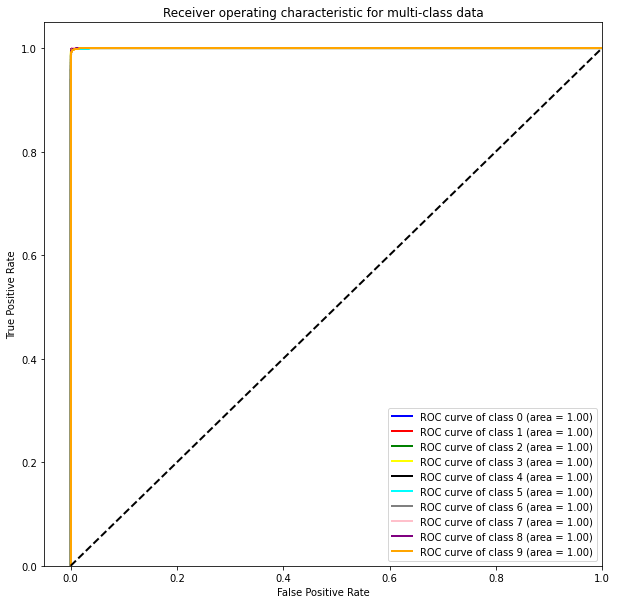

In [274]:
plot_ROC(Y_test,predicted)

# Imbalanced MNIST

In [275]:
batch_size = 128
epochs = 25
noise_ratio = 0
alpha = 1.0
beta = 1.0

X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

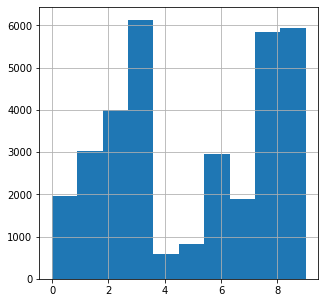

In [276]:
X_train,Y_train = Imbalanced(X_train,y_train)

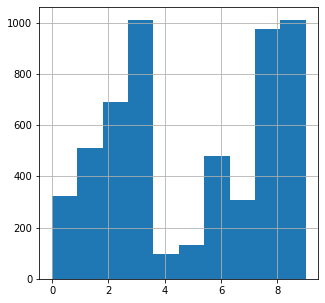

In [277]:
X_test, Y_test = Imbalanced(X_test,y_test)

In [278]:
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 33144 num_classes 10 image_shape: (28, 28, 1)


In [279]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = SGD(lr=0.1, decay=1e-4, momentum=0.9)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [280]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [281]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [282]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [283]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
258/258 [==============================] - 6s 18ms/step - loss: 0.5740 - accuracy: 0.9609 - val_loss: 0.2339 - val_accuracy: 0.9830
Epoch 2/25
258/258 [==============================] - 4s 16ms/step - loss: 0.1890 - accuracy: 0.9872 - val_loss: 0.2087 - val_accuracy: 0.9857
Epoch 3/25
258/258 [==============================] - 4s 17ms/step - loss: 0.1317 - accuracy: 0.9914 - val_loss: 0.2046 - val_accuracy: 0.9852
Epoch 4/25
258/258 [==============================] - 4s 16ms/step - loss: 0.0932 - accuracy: 0.9940 - val_loss: 0.2122 - val_accuracy: 0.9850
Epoch 5/25
258/258 [==============================] - 4s 17ms/step - loss: 0.0752 - accuracy: 0.9951 - val_loss: 0.1769 - val_accuracy: 0.9884
Epoch 6/25
258/258 [==============================] - 4s 16ms/step - loss: 0.0480 - accuracy: 0.9968 - val_loss: 0.1547 - val_accuracy: 0.9890
Epoch 7/25
258/258 [==============================] - 4s 17ms/step - loss: 0.0424 - accuracy: 0.9974 - val_loss: 0.2313 - val_accuracy: 0.9839

In [284]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.9913279414176941

In [285]:
matrix

array([[ 322,    0,    0,    0,    0,    0,    1,    0,    0,    0],
       [   0,  509,    0,    0,    0,    0,    0,    0,    1,    0],
       [   1,    1,  686,    0,    0,    0,    0,    2,    1,    0],
       [   0,    0,    0, 1008,    0,    2,    0,    0,    0,    0],
       [   0,    0,    0,    0,   94,    0,    0,    0,    1,    3],
       [   0,    0,    0,    2,    0,  128,    3,    0,    0,    0],
       [   3,    3,    1,    0,    0,    1,  470,    0,    1,    0],
       [   0,    0,    2,    0,    0,    0,    0,  303,    1,    2],
       [   1,    0,    1,    1,    0,    0,    0,    0,  970,    1],
       [   1,    0,    0,    0,    4,    1,    0,    2,    4,  997]])

In [286]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.985738298628297
Accuracy:0.9913279132791328
Recall:0.985738298628297
f1 score:0.9856712068514346


In [287]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [288]:
roc_auc

0.9998731686561362

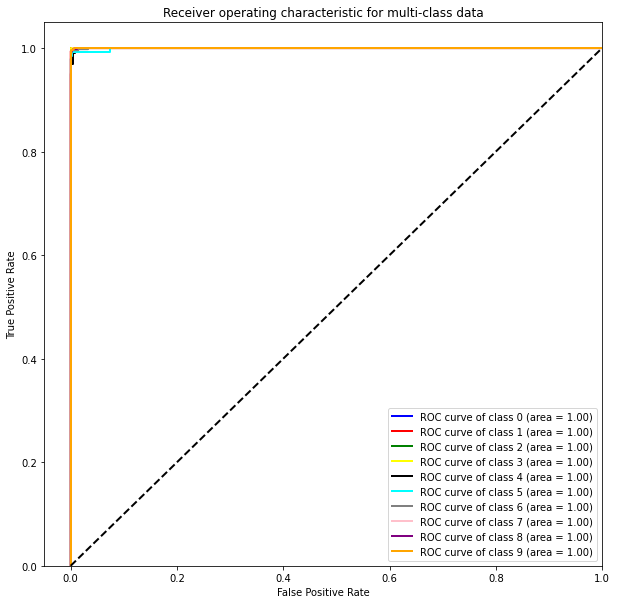

In [289]:
plot_ROC(Y_test,predicted)

# Symmetric Noise with Balanced MNIST

In [308]:
batch_size = 128
epochs = 25
noise_ratio = 60
alpha = 1.0
beta = 1.0

In [309]:
X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)
X_train,Y_train = SYM_Noise(X_train,y_train,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 5944 samples.
Noisy class 1, has 6662 samples.
Noisy class 2, has 5914 samples.
Noisy class 3, has 6083 samples.
Noisy class 4, has 5912 samples.
Noisy class 5, has 5482 samples.
Noisy class 6, has 5890 samples.
Noisy class 7, has 6220 samples.
Noisy class 8, has 5859 samples.
Noisy class 9, has 6034 samples.


In [310]:
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,y_test)

In [311]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 60000 num_classes 10 image_shape: (28, 28, 1)


In [312]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = SGD(lr=0.1, decay=1e-4, momentum=0.9)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [313]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [314]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [315]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [316]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
468/468 [==============================] - 14s 26ms/step - loss: 7.0889 - accuracy: 0.5414 - val_loss: 1.9453 - val_accuracy: 0.9799
Epoch 2/25
468/468 [==============================] - 9s 20ms/step - loss: 6.8148 - accuracy: 0.5552 - val_loss: 1.5828 - val_accuracy: 0.9823
Epoch 3/25
468/468 [==============================] - 9s 20ms/step - loss: 6.7527 - accuracy: 0.5576 - val_loss: 1.3347 - val_accuracy: 0.9828
Epoch 4/25
468/468 [==============================] - 8s 17ms/step - loss: 6.6954 - accuracy: 0.5594 - val_loss: 1.3227 - val_accuracy: 0.9886
Epoch 5/25
468/468 [==============================] - 8s 17ms/step - loss: 6.6475 - accuracy: 0.5602 - val_loss: 1.1523 - val_accuracy: 0.9866
Epoch 6/25
468/468 [==============================] - 8s 17ms/step - loss: 6.5953 - accuracy: 0.5616 - val_loss: 1.7099 - val_accuracy: 0.9856
Epoch 7/25
468/468 [==============================] - 8s 16ms/step - loss: 6.5592 - accuracy: 0.5626 - val_loss: 1.1162 - val_accuracy: 0.985

In [317]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.7540000081062317

In [318]:
matrix

array([[ 748,    6,   27,   34,   13,   29,   16,   44,   27,   36],
       [   6, 1064,    6,    7,    2,   11,   21,    9,    2,    7],
       [  43,   21,  740,   25,   16,   48,   37,   39,   29,   34],
       [  18,   16,   55,  664,   16,   52,   30,   73,   47,   39],
       [  22,   41,   32,   15,  656,   59,   31,   47,   18,   61],
       [  30,   28,   33,   25,    6,  619,   29,   42,   54,   26],
       [  18,   15,   18,   13,   11,   17,  767,   44,   16,   39],
       [  34,   13,   27,   11,    7,   22,   32,  822,   20,   40],
       [  45,   20,   35,   25,    6,   40,   57,   36,  676,   34],
       [  19,   19,   18,   20,   16,   42,   26,   39,   26,  784]])

In [319]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.7892299979721883
Accuracy:0.7309
Recall:0.7892299979721883
f1 score:0.7541231229802573


In [320]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [321]:
roc_auc

0.9571547561823779

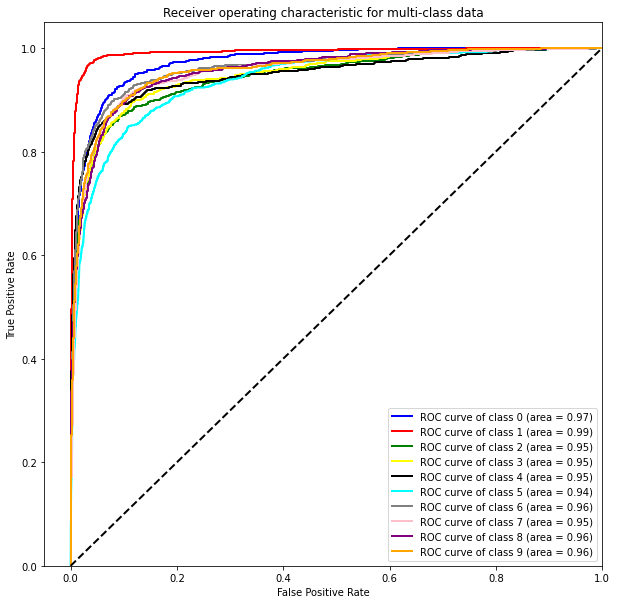

In [322]:
plot_ROC(Y_test,predicted)

# Asymmetric Noise with Balanced MNIST

In [323]:
batch_size = 128
epochs = 25
noise_ratio = 60
alpha = 1.0
beta = 1.0
source_class = [7, 2, 3, 5, 6, 1, 4]
target_class = [1, 7, 8, 6, 0, 4, 1]

In [324]:
X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)
X_train,Y_train = ASYM_Noise(X_train,y_train,source_class,target_class,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 8575 samples.
Noisy class 1, has 9217 samples.
Noisy class 2, has 3250 samples.
Noisy class 3, has 3355 samples.
Noisy class 4, has 6194 samples.
Noisy class 5, has 2954 samples.
Noisy class 6, has 5733 samples.
Noisy class 7, has 6146 samples.
Noisy class 8, has 8627 samples.
Noisy class 9, has 5949 samples.


In [325]:
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,y_test)

In [326]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 60000 num_classes 10 image_shape: (28, 28, 1)


In [327]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = SGD(lr=0.1, decay=1e-4, momentum=0.9)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [328]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [329]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [330]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [331]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
468/468 [==============================] - 9s 17ms/step - loss: 4.2615 - accuracy: 0.6430 - val_loss: 2.5813 - val_accuracy: 0.8010
Epoch 2/25
468/468 [==============================] - 8s 17ms/step - loss: 3.9421 - accuracy: 0.6611 - val_loss: 3.0818 - val_accuracy: 0.8062
Epoch 3/25
468/468 [==============================] - 8s 16ms/step - loss: 3.8633 - accuracy: 0.6640 - val_loss: 3.4054 - val_accuracy: 0.7016
Epoch 4/25
468/468 [==============================] - 8s 16ms/step - loss: 3.8135 - accuracy: 0.6730 - val_loss: 3.1472 - val_accuracy: 0.7953
Epoch 5/25
468/468 [==============================] - 8s 16ms/step - loss: 3.7676 - accuracy: 0.6750 - val_loss: 2.7883 - val_accuracy: 0.7616
Epoch 6/25
468/468 [==============================] - 8s 16ms/step - loss: 3.6998 - accuracy: 0.6841 - val_loss: 2.6084 - val_accuracy: 0.8393
Epoch 7/25
468/468 [==============================] - 8s 16ms/step - loss: 3.6515 - accuracy: 0.6885 - val_loss: 2.3835 - val_accuracy: 0.8598

In [332]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.677299976348877

In [333]:
matrix

array([[974,   0,   1,   1,   0,   0,   1,   1,   2,   0],
       [  2, 724,   0,   2, 397,   0,   4,   1,   5,   0],
       [  4,   5, 582,   3,   1,   0,   1, 420,  15,   1],
       [  0,   0,   1, 558,   0,   1,   1,   2, 447,   0],
       [  2, 478,   0,   0, 484,   0,   0,   2,   6,  10],
       [  1,   2,   0,   7,   0, 384, 492,   0,   6,   0],
       [298,   2,   0,   0,   3,   1, 648,   0,   6,   0],
       [  0, 534,   5,   3,   1,   0,   0, 472,   6,   7],
       [  0,   0,   1,   0,   1,   0,   1,   1, 968,   2],
       [  0,   7,   0,   1,   3,   4,   2,   1,  12, 979]])

In [334]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.7389849618245433
Accuracy:0.6771
Recall:0.7389849618245433
f1 score:0.6773303821384337


In [335]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [336]:
roc_auc

0.9700535897345256

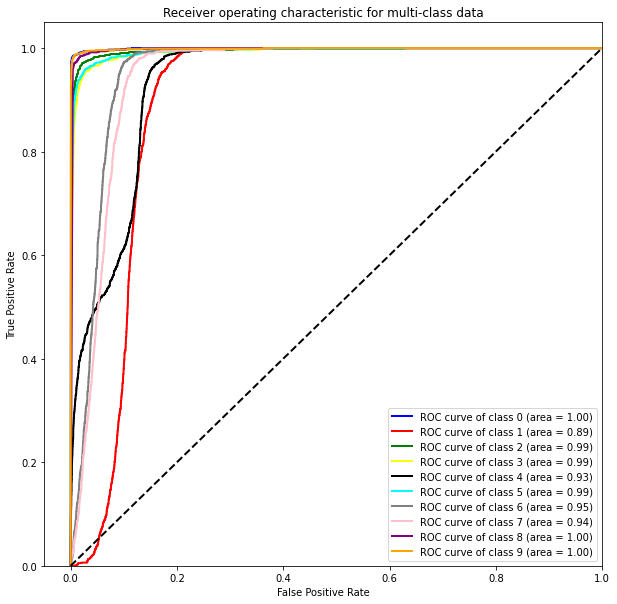

In [337]:
plot_ROC(Y_test,predicted)

# Symmetric Noise with Imbalanced MNIST

In [338]:
batch_size = 128
epochs = 25
noise_ratio = 60
alpha = 1.0
beta = 1.0

X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

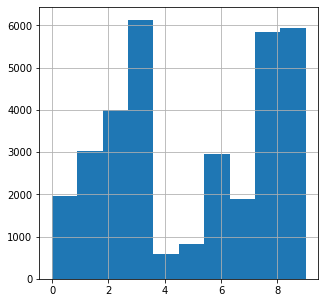

In [339]:
X_train,Y_train = Imbalanced(X_train,y_train)

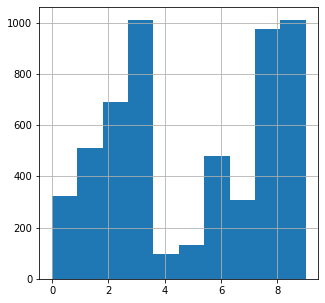

In [340]:
X_test, Y_test = Imbalanced(X_test,y_test)

In [341]:
X_train,Y_train = SYM_Noise(X_train,Y_train,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 2081 samples.
Noisy class 1, has 2897 samples.
Noisy class 2, has 3697 samples.
Noisy class 3, has 5791 samples.
Noisy class 4, has 1456 samples.
Noisy class 5, has 1463 samples.
Noisy class 6, has 2802 samples.
Noisy class 7, has 1967 samples.
Noisy class 8, has 5419 samples.
Noisy class 9, has 5571 samples.


In [342]:
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)

In [343]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 33144 num_classes 10 image_shape: (28, 28, 1)


In [344]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = SGD(lr=0.1, decay=1e-4, momentum=0.9)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [345]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [346]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [347]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [348]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
258/258 [==============================] - 59s 223ms/step - loss: 6.3939 - accuracy: 0.5846 - val_loss: 2.9232 - val_accuracy: 0.9364
Epoch 2/25
258/258 [==============================] - 4s 17ms/step - loss: 6.0712 - accuracy: 0.5998 - val_loss: 1.5195 - val_accuracy: 0.9453
Epoch 3/25
258/258 [==============================] - 4s 16ms/step - loss: 5.9794 - accuracy: 0.6047 - val_loss: 1.6886 - val_accuracy: 0.9481
Epoch 4/25
258/258 [==============================] - 4s 17ms/step - loss: 5.9129 - accuracy: 0.6079 - val_loss: 1.3500 - val_accuracy: 0.9500
Epoch 5/25
258/258 [==============================] - 4s 17ms/step - loss: 5.8459 - accuracy: 0.6098 - val_loss: 1.4313 - val_accuracy: 0.9491
Epoch 6/25
258/258 [==============================] - 4s 17ms/step - loss: 5.8019 - accuracy: 0.6123 - val_loss: 1.9135 - val_accuracy: 0.9512
Epoch 7/25
258/258 [==============================] - 4s 17ms/step - loss: 5.7231 - accuracy: 0.6161 - val_loss: 1.6856 - val_accuracy: 0.93

In [349]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.7266486287117004

In [350]:
matrix

array([[203,  29,   3,  17,  12,   4,  26,   2,  19,   8],
       [  6, 420,  16,   5,   4,   1,  17,  14,  20,   7],
       [ 26,  32, 523,  33,  11,   3,  34,  12,   7,  10],
       [ 43,  21,  29, 821,  17,   5,  33,  14,  18,   9],
       [ 12,   5,   6,   7,  13,   1,  20,   5,  16,  13],
       [ 17,  21,   2,  18,   9,   6,  19,   9,  27,   5],
       [ 18,  19,  13,  12,  10,   4, 315,  10,  75,   3],
       [ 39,  25,  63,  15,  10,   1,  21,  83,  17,  34],
       [ 23,  44,  14,  12,  13,   3,  42,   5, 807,  11],
       [ 37,  17,  32,  18,   7,   4,  39,   5,  19, 831]])

In [351]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.59227698251557
Accuracy:0.7167118337850045
Recall:0.59227698251557
f1 score:0.5679968070543626


In [352]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [353]:
roc_auc

0.8734870515512873

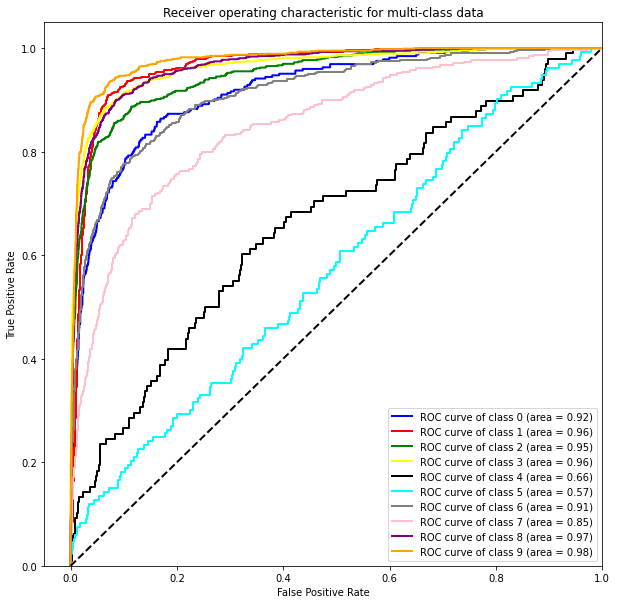

In [354]:
plot_ROC(Y_test,predicted)

# Asymmetric Noise with Imbalanced MNIST

In [355]:
batch_size = 128
epochs = 25
noise_ratio = 60
alpha = 1.0
beta = 1.0
source_class = [7, 2, 3, 5, 6, 1, 4]
target_class = [1, 7, 8, 6, 0, 4, 1]

X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

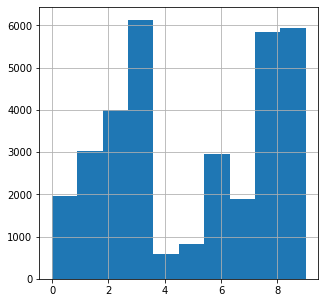

In [356]:
X_train,Y_train = Imbalanced(X_train,y_train)

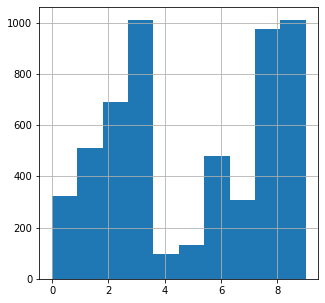

In [357]:
X_test, Y_test = Imbalanced(X_test,y_test)

In [358]:
X_train,Y_train = ASYM_Noise(X_train,Y_train,source_class,target_class,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 3272 samples.
Noisy class 1, has 2765 samples.
Noisy class 2, has 2165 samples.
Noisy class 3, has 3369 samples.
Noisy class 4, has 1685 samples.
Noisy class 5, has 438 samples.
Noisy class 6, has 2016 samples.
Noisy class 7, has 2872 samples.
Noisy class 8, has 8613 samples.
Noisy class 9, has 5949 samples.


In [359]:
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)

In [360]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 33144 num_classes 10 image_shape: (28, 28, 1)


In [361]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = SGD(lr=0.1, decay=1e-4, momentum=0.9)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [362]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [363]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [364]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [365]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
258/258 [==============================] - 6s 18ms/step - loss: 3.7740 - accuracy: 0.6902 - val_loss: 2.3556 - val_accuracy: 0.9104
Epoch 2/25
258/258 [==============================] - 4s 17ms/step - loss: 3.3225 - accuracy: 0.7160 - val_loss: 3.7395 - val_accuracy: 0.7010
Epoch 3/25
258/258 [==============================] - 4s 16ms/step - loss: 3.2167 - accuracy: 0.7252 - val_loss: 2.7836 - val_accuracy: 0.7958
Epoch 4/25
258/258 [==============================] - 4s 17ms/step - loss: 3.1435 - accuracy: 0.7315 - val_loss: 2.7074 - val_accuracy: 0.8116
Epoch 5/25
258/258 [==============================] - 4s 17ms/step - loss: 3.0909 - accuracy: 0.7382 - val_loss: 2.3105 - val_accuracy: 0.8556
Epoch 6/25
258/258 [==============================] - 4s 17ms/step - loss: 2.9923 - accuracy: 0.7500 - val_loss: 2.5753 - val_accuracy: 0.7861
Epoch 7/25
258/258 [==============================] - 4s 17ms/step - loss: 2.9108 - accuracy: 0.7572 - val_loss: 2.9397 - val_accuracy: 0.7837

In [366]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.7389340400695801

In [367]:
matrix

array([[320,   0,   1,   0,   0,   0,   1,   0,   1,   0],
       [  1, 343,   0,   1, 158,   0,   3,   0,   4,   0],
       [  0,   3, 342,   4,   0,   0,   1, 331,  10,   0],
       [  0,   0,   1, 605,   0,   1,   1,   2, 399,   1],
       [  0,  57,   0,   0,  32,   0,   0,   0,   2,   7],
       [  0,   0,   0,   5,   0,  80,  44,   1,   2,   1],
       [194,   1,   0,   0,   0,   1, 279,   1,   3,   0],
       [  0, 165,   0,   2,   0,   0,   0, 135,   4,   2],
       [  0,   1,   1,   2,   0,   0,   0,   1, 968,   1],
       [  3,   4,   0,   3,   0,   1,   0,   4,   8, 986]])

In [368]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.7128645492075519
Accuracy:0.7385727190605239
Recall:0.7128645492075519
f1 score:0.6592152964340883


In [369]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [370]:
roc_auc

0.9752297362255815

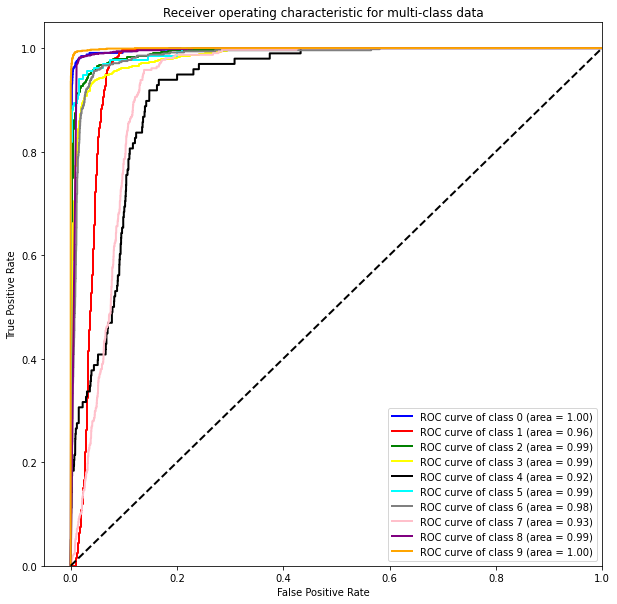

In [371]:
plot_ROC(Y_test,predicted)

# **Proposed SL**

## Balanced

In [372]:
batch_size = 128
epochs = 25
noise_ratio = 0
alpha = 1.0
beta = 1.0

X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,y_train.ravel())
X_test,Y_test = sm.fit_resample(X_test,y_test.ravel())
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)

In [373]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 67420 num_classes 10 image_shape: (28, 28, 1)


In [374]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = Adam(lr=0.1)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

In [375]:
callbacks = []
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)

cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [376]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

datagen = ImageDataGenerator()
datagen.fit(X_train)

In [377]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
526/526 [==============================] - 10s 17ms/step - loss: 0.6795 - accuracy: 0.9558 - val_loss: 1.4449 - val_accuracy: 0.9172
Epoch 2/25
526/526 [==============================] - 9s 17ms/step - loss: 0.4733 - accuracy: 0.9736 - val_loss: 0.5304 - val_accuracy: 0.9720
Epoch 3/25
526/526 [==============================] - 9s 17ms/step - loss: 0.4479 - accuracy: 0.9772 - val_loss: 0.7982 - val_accuracy: 0.9624
Epoch 4/25
526/526 [==============================] - 9s 16ms/step - loss: 0.5369 - accuracy: 0.9751 - val_loss: 2.0002 - val_accuracy: 0.9155
Epoch 5/25
526/526 [==============================] - 9s 16ms/step - loss: 0.5930 - accuracy: 0.9740 - val_loss: 0.4976 - val_accuracy: 0.9787
Epoch 6/25
526/526 [==============================] - 9s 16ms/step - loss: 0.5724 - accuracy: 0.9757 - val_loss: 0.5688 - val_accuracy: 0.9761
Epoch 7/25
526/526 [==============================] - 9s 16ms/step - loss: 0.6295 - accuracy: 0.9737 - val_loss: 0.7988 - val_accuracy: 0.967

In [378]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

In [379]:
matrix

array([[1126,    0,    1,    0,    0,    0,    5,    1,    2,    0],
       [   0, 1130,    1,    1,    0,    0,    0,    3,    0,    0],
       [   3,    6, 1115,    0,    1,    0,    0,    7,    3,    0],
       [   2,    1,   14, 1103,    0,    2,    0,    4,    6,    3],
       [   3,    0,    0,    0, 1127,    0,    1,    2,    2,    0],
       [   6,    3,    1,   14,    1, 1082,    3,    2,    9,   14],
       [  42,    5,    0,    0,    5,   16, 1062,    0,    5,    0],
       [   0,    1,   11,    4,    2,    0,    0, 1115,    1,    1],
       [   7,    0,    1,    0,   14,    2,    0,    4, 1100,    7],
       [   2,    1,    3,    2,   19,    0,    0,   12,    5, 1091]])

In [380]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.9739577844641927
Accuracy:0.9736563876651982
Recall:0.9739577844641927
f1 score:0.9736085164192065


In [381]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [382]:
roc_auc

0.9876684067871165

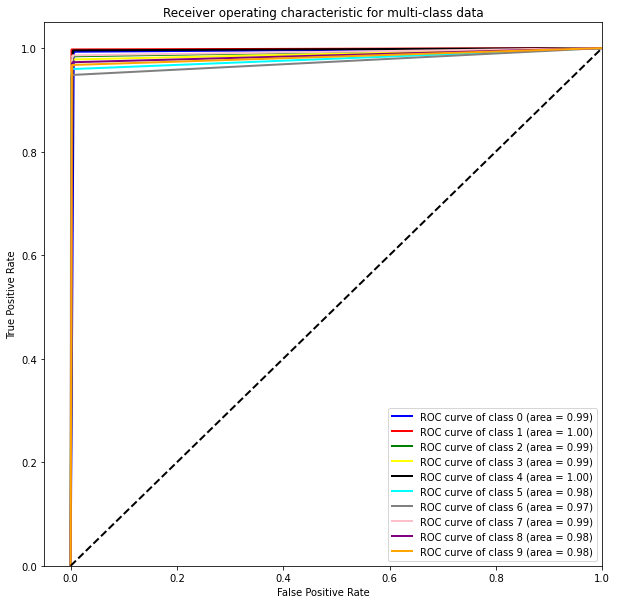

In [383]:
plot_ROC(Y_test,predicted)

## Imalanced

In [384]:
batch_size = 128
epochs = 25
noise_ratio = 0
alpha = 1.0
beta = 1.0

X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

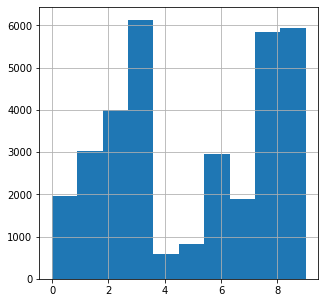

In [385]:
X_train,Y_train = Imbalanced(X_train,y_train)

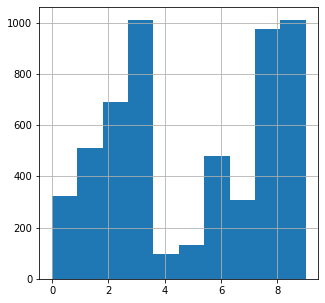

In [386]:
X_test,Y_test = Imbalanced(X_test,y_test)

In [387]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())
X_test,Y_test = sm.fit_resample(X_test,Y_test.ravel())
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)

In [388]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 61310 num_classes 10 image_shape: (28, 28, 1)


In [389]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = Adam(lr=0.1)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

In [390]:
callbacks = []
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)

cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [391]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

datagen = ImageDataGenerator()
datagen.fit(X_train)

In [392]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
478/478 [==============================] - 9s 17ms/step - loss: 0.6431 - accuracy: 0.9573 - val_loss: 0.9884 - val_accuracy: 0.9461
Epoch 2/25
478/478 [==============================] - 8s 17ms/step - loss: 0.3959 - accuracy: 0.9770 - val_loss: 1.3111 - val_accuracy: 0.9357
Epoch 3/25
478/478 [==============================] - 8s 17ms/step - loss: 0.4112 - accuracy: 0.9795 - val_loss: 1.4684 - val_accuracy: 0.9337
Epoch 4/25
478/478 [==============================] - 8s 17ms/step - loss: 0.4812 - accuracy: 0.9778 - val_loss: 0.5182 - val_accuracy: 0.9773
Epoch 5/25
478/478 [==============================] - 8s 17ms/step - loss: 0.4461 - accuracy: 0.9804 - val_loss: 0.7948 - val_accuracy: 0.9667
Epoch 6/25
478/478 [==============================] - 8s 17ms/step - loss: 0.5452 - accuracy: 0.9769 - val_loss: 1.0790 - val_accuracy: 0.9555
Epoch 7/25
478/478 [==============================] - 8s 17ms/step - loss: 0.5995 - accuracy: 0.9749 - val_loss: 0.7530 - val_accuracy: 0.9692

In [393]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

In [394]:
matrix

array([[ 995,    2,    1,    0,    1,    1,    6,    0,    3,    1],
       [   0,  995,    2,    0,    0,    1,   11,    0,    1,    0],
       [   1,   10,  956,    0,    0,    0,    1,   22,   20,    0],
       [   1,    1,    0,  977,    0,    2,    0,    4,   16,    9],
       [   0,    1,    0,    0,  983,    0,    8,    0,    0,   18],
       [   2,    0,    0,   12,    2,  970,    3,    0,   11,   10],
       [   1,    0,    0,    0,    2,    4, 1002,    0,    0,    1],
       [   0,    2,    7,    0,    1,    0,    0,  990,    3,    7],
       [   5,    1,    0,    0,    0,    1,   16,    2,  979,    6],
       [   1,    0,    0,    1,    1,    1,    1,    1,    4, 1000]])

In [395]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.9753796488368716
Accuracy:0.9749504950495049
Recall:0.9753796488368716
f1 score:0.9749827916885628


In [396]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [397]:
roc_auc

0.9881535089152479

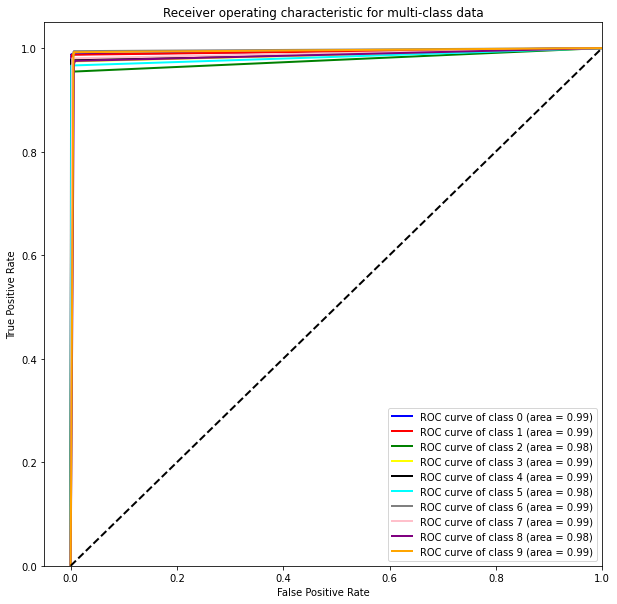

In [398]:
plot_ROC(Y_test,predicted)

## Symmetric Noise with Balanced MNIST

In [399]:
batch_size = 128
epochs = 25
noise_ratio = 60
alpha = 1.0
beta = 1.0

In [400]:
X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)
X_train,Y_train = SYM_Noise(X_train,y_train,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 5894 samples.
Noisy class 1, has 6700 samples.
Noisy class 2, has 6020 samples.
Noisy class 3, has 6065 samples.
Noisy class 4, has 5862 samples.
Noisy class 5, has 5459 samples.
Noisy class 6, has 5970 samples.
Noisy class 7, has 6258 samples.
Noisy class 8, has 5808 samples.
Noisy class 9, has 5964 samples.


In [401]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())
X_test,Y_test = sm.fit_resample(X_test,y_test.ravel())
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)

In [402]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 67000 num_classes 10 image_shape: (28, 28, 1)


In [403]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = Adam(lr=0.1)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [404]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [405]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [406]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [407]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
523/523 [==============================] - 10s 17ms/step - loss: 7.2794 - accuracy: 0.5307 - val_loss: 2.1886 - val_accuracy: 0.9154
Epoch 2/25
523/523 [==============================] - 9s 17ms/step - loss: 6.9672 - accuracy: 0.5493 - val_loss: 1.5091 - val_accuracy: 0.9537
Epoch 3/25
523/523 [==============================] - 9s 17ms/step - loss: 6.9354 - accuracy: 0.5512 - val_loss: 1.6842 - val_accuracy: 0.9690
Epoch 4/25
523/523 [==============================] - 9s 17ms/step - loss: 6.8728 - accuracy: 0.5530 - val_loss: 1.6350 - val_accuracy: 0.9738
Epoch 5/25
523/523 [==============================] - 9s 17ms/step - loss: 6.8372 - accuracy: 0.5544 - val_loss: 2.3825 - val_accuracy: 0.9457
Epoch 6/25
523/523 [==============================] - 9s 17ms/step - loss: 6.8131 - accuracy: 0.5551 - val_loss: 1.3214 - val_accuracy: 0.9809
Epoch 7/25
523/523 [==============================] - 9s 17ms/step - loss: 6.8085 - accuracy: 0.5562 - val_loss: 1.4617 - val_accuracy: 0.977

In [408]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.9469603300094604

In [409]:
matrix

array([[1097,    1,   11,    0,    0,    7,   13,    1,    1,    4],
       [   4, 1112,    3,    2,    5,    2,    5,    2,    0,    0],
       [   4,    0, 1107,    3,    2,    9,    2,    5,    2,    1],
       [   2,    0,   28, 1071,    2,   18,    0,    6,    4,    4],
       [   1,    6,    7,    1, 1057,    5,    7,    5,    6,   40],
       [   3,    0,    7,   21,    2, 1057,   16,    4,   17,    8],
       [   5,    1,    7,    1,   11,   14, 1088,    0,    6,    2],
       [   1,    1,   27,    6,    9,   13,    0, 1067,    3,    8],
       [  15,    0,   33,    9,    5,   23,   16,    1, 1015,   18],
       [   3,    0,    7,    2,   17,   17,    2,    6,    4, 1077]])

In [410]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.9760535880190127
Accuracy:0.8771806167400881
Recall:0.9760535880190127
f1 score:0.9223098466381094


In [411]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [412]:
roc_auc

0.9945343528239763

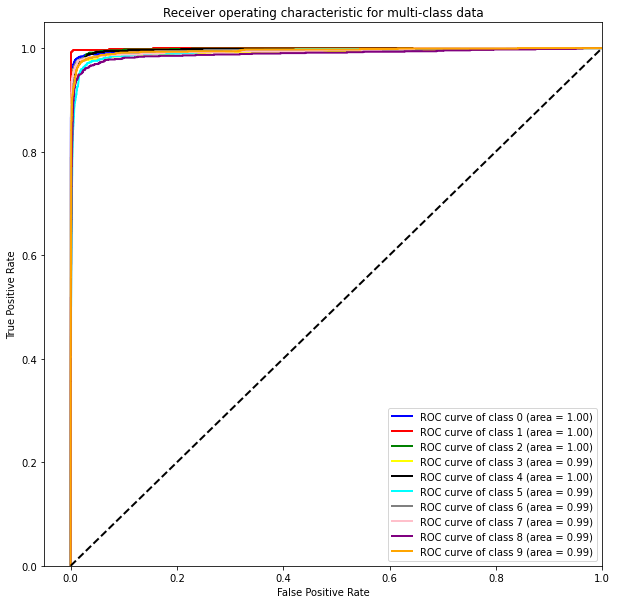

In [413]:
plot_ROC(Y_test,predicted)

## Asymmetric Noise with Balanced MNIST

In [414]:
batch_size = 512
epochs = 25
noise_ratio = 60
alpha = 1.0
beta = 1.0
source_class = [7, 2, 3, 5, 6, 1, 4]
target_class = [1, 7, 8, 6, 0, 4, 1]

In [415]:
X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)
X_train,Y_train = ASYM_Noise(X_train,y_train,source_class,target_class,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 8559 samples.
Noisy class 1, has 9160 samples.
Noisy class 2, has 3268 samples.
Noisy class 3, has 3398 samples.
Noisy class 4, has 6236 samples.
Noisy class 5, has 2951 samples.
Noisy class 6, has 5752 samples.
Noisy class 7, has 6143 samples.
Noisy class 8, has 8584 samples.
Noisy class 9, has 5949 samples.


In [416]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())
X_test,Y_test = sm.fit_resample(X_test,y_test.ravel())
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)

In [417]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 91600 num_classes 10 image_shape: (28, 28, 1)


In [418]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = Adam(lr=0.1)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [419]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [420]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [421]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [422]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
178/178 [==============================] - 9s 46ms/step - loss: 3.6556 - accuracy: 0.7109 - val_loss: 2.6422 - val_accuracy: 0.8258
Epoch 2/25
178/178 [==============================] - 8s 43ms/step - loss: 3.2081 - accuracy: 0.7373 - val_loss: 2.9352 - val_accuracy: 0.8244
Epoch 3/25
178/178 [==============================] - 8s 43ms/step - loss: 3.1209 - accuracy: 0.7418 - val_loss: 2.2353 - val_accuracy: 0.8330
Epoch 4/25
178/178 [==============================] - 8s 44ms/step - loss: 3.0777 - accuracy: 0.7451 - val_loss: 2.4487 - val_accuracy: 0.8501
Epoch 5/25
178/178 [==============================] - 8s 43ms/step - loss: 3.0745 - accuracy: 0.7454 - val_loss: 2.8655 - val_accuracy: 0.7812
Epoch 6/25
178/178 [==============================] - 8s 44ms/step - loss: 3.0152 - accuracy: 0.7511 - val_loss: 2.1654 - val_accuracy: 0.8672
Epoch 7/25
178/178 [==============================] - 8s 44ms/step - loss: 2.9963 - accuracy: 0.7499 - val_loss: 2.7405 - val_accuracy: 0.8063

In [423]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.6806167364120483

In [424]:
matrix

array([[1124,    1,    0,    0,    0,    2,    7,    0,    1,    0],
       [   0,  898,    0,    0,  237,    0,    0,    0,    0,    0],
       [   8,   30,  448,    0,    2,    0,    1,  640,    6,    0],
       [   5,    9,    1,  535,    1,    4,    1,    1,  577,    1],
       [   1,  455,    1,    0,  669,    0,    1,    0,    0,    8],
       [   8,    2,    0,    6,    1,  809,  301,    0,    8,    0],
       [ 596,    4,    0,    0,    2,    1,  531,    0,    1,    0],
       [   0,  601,    1,    0,    8,    0,    0,  521,    1,    3],
       [   7,    6,    3,    1,    3,    3,    3,    4, 1095,   10],
       [   0,   22,    0,    1,    6,    0,    1,    3,    7, 1095]])

In [425]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.7472931358269388
Accuracy:0.68
Recall:0.7472931358269388
f1 score:0.67583877281241


In [426]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [427]:
roc_auc

0.9759753062461052

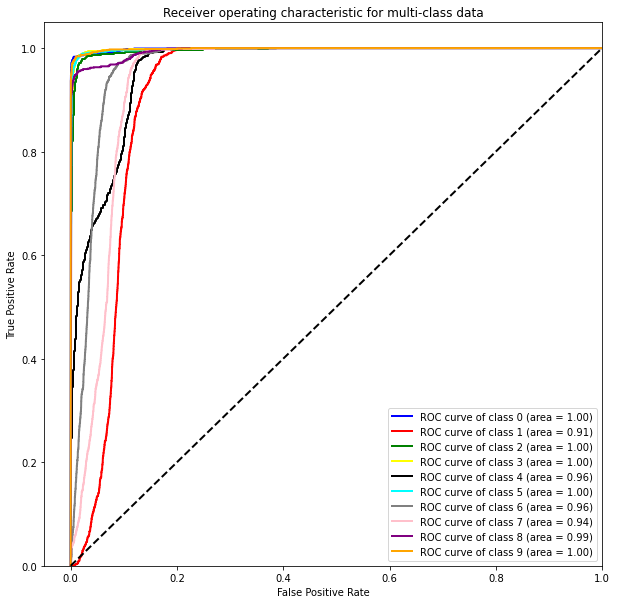

In [428]:
plot_ROC(Y_test,predicted)

## Symmetric Noise with Imbalanced MNIST

In [429]:
batch_size = 128
epochs = 25
noise_ratio = 60
alpha = 1.0
beta = 1.0

X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

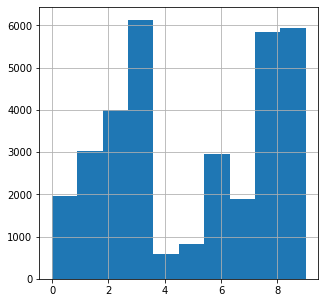

In [430]:
X_train,Y_train = Imbalanced(X_train,y_train)

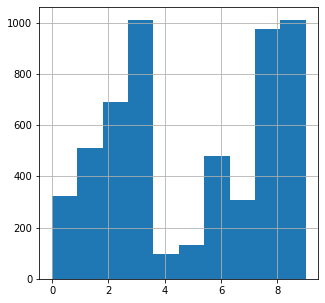

In [431]:
X_test, Y_test = Imbalanced(X_test,y_test)

In [432]:
X_train,Y_train = SYM_Noise(X_train,Y_train,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 2031 samples.
Noisy class 1, has 2877 samples.
Noisy class 2, has 3745 samples.
Noisy class 3, has 5748 samples.
Noisy class 4, has 1479 samples.
Noisy class 5, has 1479 samples.
Noisy class 6, has 2876 samples.
Noisy class 7, has 1951 samples.
Noisy class 8, has 5467 samples.
Noisy class 9, has 5491 samples.


In [433]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())
X_test,Y_test = sm.fit_resample(X_test,Y_test.ravel())
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)

In [434]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 57480 num_classes 10 image_shape: (28, 28, 1)


In [435]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = Adam(lr=0.1)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [436]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [437]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [438]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [439]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
449/449 [==============================] - 9s 18ms/step - loss: 7.4091 - accuracy: 0.4878 - val_loss: 3.2471 - val_accuracy: 0.8511
Epoch 2/25
449/449 [==============================] - 8s 17ms/step - loss: 7.1276 - accuracy: 0.5073 - val_loss: 4.5090 - val_accuracy: 0.6658
Epoch 3/25
449/449 [==============================] - 8s 17ms/step - loss: 7.0184 - accuracy: 0.5131 - val_loss: 3.6725 - val_accuracy: 0.8004
Epoch 4/25
449/449 [==============================] - 8s 17ms/step - loss: 6.9015 - accuracy: 0.5233 - val_loss: 4.0193 - val_accuracy: 0.7697
Epoch 5/25
449/449 [==============================] - 8s 17ms/step - loss: 6.7970 - accuracy: 0.5314 - val_loss: 3.2666 - val_accuracy: 0.8297
Epoch 6/25
449/449 [==============================] - 8s 17ms/step - loss: 6.7087 - accuracy: 0.5385 - val_loss: 3.8318 - val_accuracy: 0.7579
Epoch 7/25
449/449 [==============================] - 7s 17ms/step - loss: 6.6110 - accuracy: 0.5476 - val_loss: 3.9187 - val_accuracy: 0.7499

In [440]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.7305940389633179

In [441]:
matrix

array([[717,   1,   7,   0, 151,  74,  23,  14,  16,   7],
       [ 34, 843,  18,   0,  51,  40,   3,  21,   0,   0],
       [ 37,   2, 905,   8,  19,  23,   3,   7,   5,   1],
       [ 13,   0,   7, 980,   1,   2,   2,   1,   3,   1],
       [155,  14,   2,   2, 284, 254,  24, 218,  23,  34],
       [260,  14,   1,  37, 248, 272,  78,  61,  15,  24],
       [ 36,   0,   6,   0, 113,  22, 818,   6,   5,   4],
       [ 38,   1,  40,  16,  90,  83,   0, 731,   3,   8],
       [ 46,   1,  24,   5,  12,   8,   2,   5, 901,   6],
       [  3,   7,   2,  10,   5,  18,   0,  25,  12, 928]])

In [442]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.7589280749502535
Accuracy:0.6987128712871287
Recall:0.7589280749502535
f1 score:0.7258234240643144


In [443]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [444]:
roc_auc

0.9157722608894554

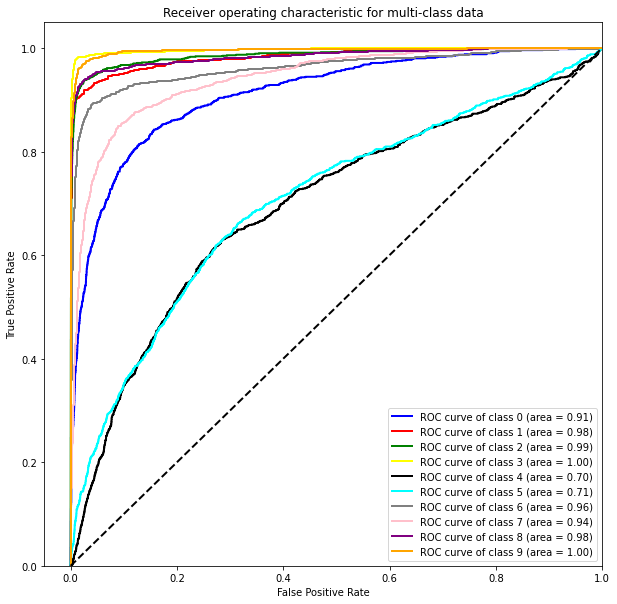

In [445]:
plot_ROC(Y_test,predicted)

## Asymmetric Noise with Imbalanced MNIST

In [446]:
batch_size = 128
epochs = 25
noise_ratio = 60
alpha = 1.0
beta = 1.0
source_class = [7, 2, 3, 5, 6, 1, 4]
target_class = [1, 7, 8, 6, 0, 4, 1]

X_train,y_train,X_test,y_test = load_data()
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

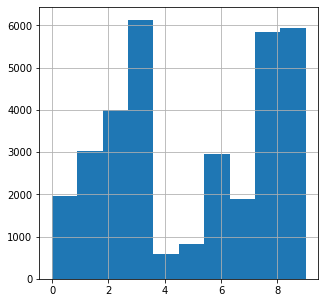

In [447]:
X_train,Y_train = Imbalanced(X_train,y_train)

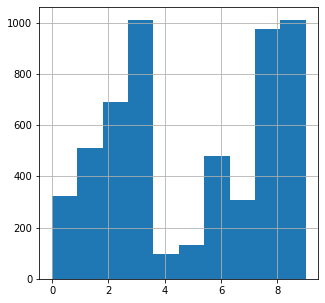

In [448]:
X_test, Y_test = Imbalanced(X_test,y_test)

In [449]:
X_train,Y_train = ASYM_Noise(X_train,Y_train,source_class,target_class,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 3286 samples.
Noisy class 1, has 2768 samples.
Noisy class 2, has 2183 samples.
Noisy class 3, has 3371 samples.
Noisy class 4, has 1686 samples.
Noisy class 5, has 449 samples.
Noisy class 6, has 1991 samples.
Noisy class 7, has 2850 samples.
Noisy class 8, has 8611 samples.
Noisy class 9, has 5949 samples.


In [450]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())
X_test,Y_test = sm.fit_resample(X_test,Y_test.ravel())
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train = preprocess(X_train,Y_train,X_test,Y_test)

In [451]:
n_images = X_train.shape[0]
image_shape = X_train.shape[1:]
num_classes = Y_train.shape[1]
print("n_images", n_images, "num_classes", num_classes, "image_shape:", image_shape)

n_images 86110 num_classes 10 image_shape: (28, 28, 1)


In [452]:
P = np.eye(num_classes)
model = get_model(input_tensor=None, input_shape=image_shape, num_classes=num_classes)
optimizer = Adam(lr=0.1)
loss = symmetric_cross_entropy(alpha,beta)
# model
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
callbacks = []

In [453]:
model_save_file = "model/sl_mnist_%s.{epoch:02d}.hdf5" % (noise_ratio)
cp_callback = ModelCheckpoint(model_save_file,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=False,
                              save_weights_only=True,
                              period=1)
callbacks.append(cp_callback)

In [454]:
# learning rate scheduler if use sgd
lr_scheduler = get_lr_scheduler(epochs)
callbacks.append(lr_scheduler)

callbacks.append(SGDLearningRateTracker(model))

In [455]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [456]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    )

Epoch 1/25
672/672 [==============================] - 12s 16ms/step - loss: 3.7333 - accuracy: 0.7088 - val_loss: 1.4920 - val_accuracy: 0.8963
Epoch 2/25
672/672 [==============================] - 11s 16ms/step - loss: 3.3709 - accuracy: 0.7300 - val_loss: 2.6426 - val_accuracy: 0.8066
Epoch 3/25
672/672 [==============================] - 11s 16ms/step - loss: 3.2903 - accuracy: 0.7352 - val_loss: 2.7163 - val_accuracy: 0.8291
Epoch 4/25
672/672 [==============================] - 11s 16ms/step - loss: 3.2440 - accuracy: 0.7410 - val_loss: 3.8473 - val_accuracy: 0.6563
Epoch 5/25
672/672 [==============================] - 11s 16ms/step - loss: 3.1896 - accuracy: 0.7430 - val_loss: 2.3099 - val_accuracy: 0.8652
Epoch 6/25
672/672 [==============================] - 11s 16ms/step - loss: 3.1131 - accuracy: 0.7501 - val_loss: 2.6249 - val_accuracy: 0.7951
Epoch 7/25
672/672 [==============================] - 11s 16ms/step - loss: 3.0531 - accuracy: 0.7563 - val_loss: 2.4776 - val_accuracy:

In [457]:
predicted = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
test_acc

0.7667326927185059

In [458]:
matrix

array([[986,   0,  10,   1,   0,   1,   7,   4,   1,   0],
       [  0, 414,   9,   2, 581,   3,   0,   1,   0,   0],
       [  1,   0, 909,   0,   2,   0,   0,  98,   0,   0],
       [  0,   3,   2, 923,   0,   2,   0,   4,  75,   1],
       [  7, 512,  16,   2, 450,   2,   3,  13,   5,   0],
       [  0,   1,   0,  17,   0, 845, 145,   0,   1,   1],
       [324,   7,   5,   3,   2,  11, 641,  16,   1,   0],
       [  0, 346,   0,   2,   6,   0,   0, 656,   0,   0],
       [  4,   1,  12,   9,   0,   4,   5,   4, 966,   5],
       [  2,  26,   1,   5,  11,   1,   5,   2,   3, 954]])

In [459]:
print("Precision:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, np.round(predicted))))
print("Recall:{}".format(precision_score(Y_test,np.round(predicted),average='macro')))
print("f1 score:{}".format(f1_score(Y_test,np.round(predicted),average='macro')))

Precision:0.7899783626131096
Accuracy:0.7657425742574258
Recall:0.7899783626131096
f1 score:0.7730268876505605


In [460]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, predicted,multi_class='ovr')

In [461]:
roc_auc

0.972881732727728

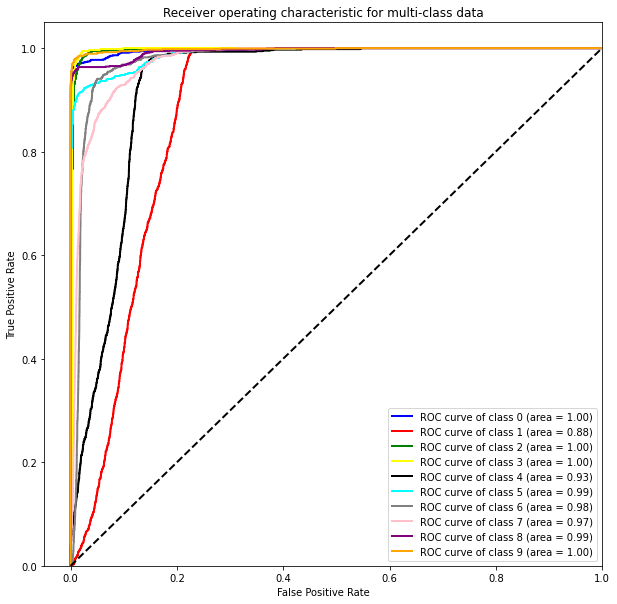

In [462]:
plot_ROC(Y_test,predicted)